## Notes:

* Created credentials, which then saved a .JSON file with credential information
* Went to PATH environments in my PC's "advanced system settings" and set the PATH to point: GOOGLE_APPLICATION_CREDENTIALS={PATH} where PATH leads to the .JSON credential file
* When tried to run received:
    * 403 Cloud Speech-to-Text API has not been used in project 155597943318 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis/api/speech.googleapis.com/overview?project=155597943318 then retry. If you enabled this API recently, wait a few minutes for the action to propagate to our systems and retry.
    * Then had to sign up and put in credit card. Have 12 month free trial and Google gave me 300 dollars worth of service(?)
* Response was empty
    * "You've got the result of the operation and it is empty. The reason of the empty result is format mismatch. You should have submitted "LINEAR16" file (PCM uncompressed data, basically WAV file) and you try to submit FLAC (compressed format). Other reason of the empty result might be incorrect sample rate, incorrect number of channels and so on. Last, the file with pure silence will result in empty response."



API Documents:
https://cloud.google.com/speech-to-text/docs/reference/libraries#client-libraries-install-python

https://github.com/GoogleCloudPlatform/python-docs-samples/tree/master/speech/cloud-client

In [1]:
import io
import os
import wave

import contextlib
import shutil
import tempfile

from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

import librosa
from librosa import display, output
from pydub import AudioSegment

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

client = speech.SpeechClient()

C:\Users\Michael\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:

# NOTE!! Later will need to move the location of the JSON file 
# Will also need to change the PATH to the file
# Recall: search for system (control panel) then advanced system settings

In [9]:
print(result.__doc__)

A speech recognition result corresponding to a portion of the audio.
  
  
  Attributes:
      alternatives:
          Output only. May contain one or more recognition hypotheses
          (up to the maximum specified in ``max_alternatives``). These
          alternatives are ordered in terms of accuracy, with the top
          (first) alternative being the most probable, as ranked by the
          recognizer.
      channel_tag:
          For multi-channel audio, this is the channel number
          corresponding to the recognized result for the audio from that
          channel. For audio\_channel\_count = N, its output values can
          range from '1' to 'N'.
  


In [10]:
print(result.alternatives[0].__doc__)

Alternative hypotheses (a.k.a. n-best list).
  
  
  Attributes:
      transcript:
          Output only. Transcript text representing the words that the
          user spoke.
      confidence:
          Output only. The confidence estimate between 0.0 and 1.0. A
          higher number indicates an estimated greater likelihood that
          the recognized words are correct. This field is set only for
          the top alternative of a non-streaming result or, of a
          streaming result where ``is_final=true``. This field is not
          guaranteed to be accurate and users should not rely on it to
          be always provided. The default of 0.0 is a sentinel value
          indicating ``confidence`` was not set.
      words:
          Output only. A list of word-specific information for each
          recognized word. Note: When ``enable_speaker_diarization`` is
          true, you will see all the words from the beginning of the
          audio.
  


In [11]:
list_swear_words = [
    "fuck", "shit", "piss off", "dick head", "asshole", "ass",
    "bitch", "bastard", "damn", "cunt", "nigger", "nigga"
]

In [12]:
def replace_swear(text):
    new_text = text
    for swear in list_swear_words:
        new_text = new_text.replace(swear, "***")
        
    return new_text

replace_swear(result.alternatives[0].transcript.lower())

'it is so ***ing nice outside'

Ok, so now we have a way to take in the audio, transcribe it (with confidence), and replace the swear (which can easily be set to a boolean instead).

This was done for a piece of clean-ish vocal audio. Now would like to see if it also works with music underneath.

In [10]:
fusc_audio_file_path = folder + "/" + "fuck_up_some_commas_sample.wav"

fusc_frame_rate = wave.open(file).getframerate()
print(fusc_frame_rate)

FileNotFoundError: [Errno 2] No such file or directory: 'It is so fucking sunny outside audio.wav'

In [45]:
import IPython.display as ipd
ipd.Audio(fusc_audio_file_path) # load a local WAV file

In [41]:
with io.open(fusc_audio_file_path, 'rb') as audio_file:
    content = audio_file.read()
    audio = types.RecognitionAudio(content=content)
    
config = types.RecognitionConfig(
    encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=fusc_frame_rate,
    language_code='en-US'
)

In [42]:
response = client.recognize(config, audio)

In [43]:
response.results

[]

So, for some reason this is not working with the recorded music. I assume it is because it is such terrible quality. Should try to download a song with swear in it instead of recording the song.

In [63]:
song_file = "Future_-_F_ck_Up_Some_Commas_(Official_Music_Video).wav"
fusm_song, sr = librosa.load(folder + "/" + song_file)

NameError: name 'plt' is not defined

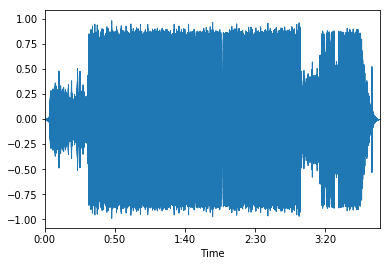

In [62]:
display.waveplot(fusm_song)
plt.show()

In [69]:
print(sr)
print(fusm_song.shape)
print((fusm_song.shape[0] / sr) // 60)
print((fusm_song.shape[0] / sr) % 60)

22050
(5266433,)
3.0
58.84049886621315


In [71]:
# want to clip from 8 second to 17 seconds

start = 8*sr
end = 17*sr

trimmed_song = fusm_song[start: end]
print(trimmed_song.shape)

(198450,)


In [75]:
output.write_wav(folder + "/" + "test_trim.wav", trimmed_song, sr=sr)

Ok, looks like it worked.

In [81]:
fusc_audio_file_path = folder + "/" + "test_trim.wav"

#fusc_frame_rate = wave.open(file).getframerate()
#print(fusc_frame_rate)

with io.open(fusc_audio_file_path, 'rb') as audio_file:
    content = audio_file.read()
    audio = types.RecognitionAudio(content=content)
    
config = types.RecognitionConfig(
    encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=22050,
    language_code='en-US'
)

response = client.recognize(config, audio)

for result in response.results:
    print("Transcript: ", result.alternatives[0].transcript)
    print("\tConfidence: ", result.alternatives[0].confidence)

InvalidArgument: 400 WAV header indicates an unsupported format.

Notes on passing music with lyrics:

* It might be a good idea to use equalization and other methods to reduce the instruments in the song. Use filters of specific ranges to take out noises in frequencies outside of normal human pitch.
    * Bandpass Filter: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
* Will need to look up other methods as well.

***

# Jun 13, 2019

### MVP2

Attempt to find the smallest box around a swear word in an audio file. Use object detection. similar to R-CNN.
https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py

https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

***

In [2]:
folder = "Data/Not_Organized"
file = "It is so fucking sunny outside audio.wav"

full_file = folder + "/" + file
print(full_file)

Data/Not_Organized/It is so fucking sunny outside audio.wav


In [3]:
frame_rate = wave.open(full_file).getframerate()

Error: unknown format: 3

Can I open a wave file using librosa as well?

In [4]:
with io.open(full_file, 'rb') as audio_file:
    content = audio_file.read()
    audio = types.RecognitionAudio(content=content)

In [8]:
config = types.RecognitionConfig(
    encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=22050,
    language_code='en-US'
)

In [9]:
def transcript_contains_swear(transcript):
    for swear in list_swear_words:
        if swear in transcript:
            return True
    return False


def audio_contains_swear(audio, config_):
    response = client.recognize(config_, audio)

    transcript = response.results[0].alternatives[0].transcript
    confidence = response.results[0].alternatives[0].confidence
    swear_in_audio = transcript_contains_swear(transcript)
    
    print("Transcript: ", transcript)
    print("Confidence: ", confidence)
    print("Does the audio contain a swear word?", swear_in_audio)
    
audio_contains_swear(audio, config)

InvalidArgument: 400 WAV header indicates an unsupported format.

Now, I need a way to break up the audio with a random start and a random end time.

Brute force method for now:

Need a temporary file.

Using Librosa or other library, split the wav file into sub-sections then save each sub-section.
Open each subsection and apply the *audio_contains_swear* method.

In [26]:
temp_folder = "temp_folder"

In [27]:
# First step, open and then save the wav file using librosa into the temp_folder location
original_audio, sr = librosa.core.load(full_file)
output.write_wav(temp_folder + "/" + file, original_audio, sr=sr)

Take a listen to ensure everything worked

In [61]:
ipd.Audio(temp_folder + "/" + file)

In [84]:
from pydub import AudioSegment

C:\Users\Michael\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [28]:
def split_by_percent_pydub(file_with_path, percent=0.5):
    newAudio = AudioSegment.from_wav(file_with_path)
    
    len_ = len(newAudio)
    slice_index = int(percent * len_)
    
    audio_slice_1 = newAudio[:slice_index]
    audio_slice_2 = newAudio[slice_index:]
    
    audio_slice_1.export(temp_folder + "/" + "test" + "_1_pydub.wav", format="wav")
    audio_slice_2.export(temp_folder + "/" + "test" + "_2_pydub.wav", format="wav")
    
split_by_percent_pydub(full_file)

In [89]:
ipd.Audio(temp_folder + "/" + "test_1_pydub.wav")

In [90]:
ipd.Audio(temp_folder + "/" + "test_2_pydub.wav")

Now, apply the *audio_contains_swear* method to each file

In [29]:
for file_ in [temp_folder + "/" + "test_1_pydub.wav", temp_folder + "/" + "test_2_pydub.wav"]:
    with io.open(file_, 'rb') as audio_file:
        content = audio_file.read()
        audio = types.RecognitionAudio(content=content)
        
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        #sample_rate_hertz=frame_rate,
        language_code='en-US'
    )

    print(file)
    audio_contains_swear(audio, config)

It is so fucking sunny outside audio.wav
Transcript:  it is so
Confidence:  0.9640713334083557
Does the audio contain a swear word? False
It is so fucking sunny outside audio.wav
Transcript:  fucking nice outside
Confidence:  0.970584511756897
Does the audio contain a swear word? True


Great this works so far!

I think the best way for this to work out will be using the google speech API as the boolean for found and run something similar to a search algorithm. Should probably use a cache to hold the current sub_section as well as the previous sub_section. This would take care of granularity later on (I think?).

Could instead use randomly selected boxes to find a "good enough" box to remove the swear words.


Information regarding tempfile for creating a temporary folder:
https://stackoverflow.com/questions/3223604/how-to-create-a-temporary-directory-and-get-the-path-file-name-in-python

In [2]:
def split_by_percent_pydub(file, folder, layer=1, percent=0.5):
    
    newAudio = AudioSegment.from_wav(os.path.join(folder, file))
    
    len_ = len(newAudio)
    slice_index = int(percent * len_)
    
    audio_slice_1 = newAudio[:slice_index]
    audio_slice_2 = newAudio[slice_index:]
    
    audio_slice_1.export(os.path.join(folder, "temp_{}_A_pydub.wav".format(layer)), format="wav")
    audio_slice_2.export(os.path.join(folder, "temp_{}_B_pydub.wav".format(layer)), format="wav")
    
def transcript_contains_swear(transcript):
    for swear in list_swear_words:
        if swear in transcript:
            return True
    return False


def audio_contains_swear(audio, config_, print_=False):
    response = client.recognize(config_, audio)

    if len(response.results) > 0:
        transcript = response.results[0].alternatives[0].transcript
        confidence = response.results[0].alternatives[0].confidence
        swear_in_audio = transcript_contains_swear(transcript)

        if print_:
            print("Transcript: ", transcript)
            print("Confidence: ", confidence)
            print("Does the audio contain a swear word?", swear_in_audio)

        return swear_in_audio
    return False
    
list_swear_words = [
    "fuck", "shit", "piss off", "dick head", "asshole", "ass",
    "bitch", "bastard", "damn", "cunt", "nigger", "nigga"
]

In [3]:
def split_and_check(files):
    for file_ in files:
        with io.open(file_, 'rb') as audio_file:
            content = audio_file.read()
            audio = types.RecognitionAudio(content=content)

            config = types.RecognitionConfig(
                encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
                language_code='en-US'
            )

            if audio_contains_swear(audio, config):
                return file_
    return None

In [59]:
folder = "temp_folder"
file = "trial_audio.wav"

original_file = os.path.join(folder, file)
#original_audio, sr = librosa.core.load(original_file)

layer = 1
split_coef = 0.5

split_by_percent_pydub(file, folder, layer, split_coef)

files_1 = [folder + "/test_{}_A_pydub.wav".format(layer), folder + "/test_{}_B_pydub.wav".format(layer)]

new_file_1 = split_and_check(files_1)

if new_file_1 is not None:
    new_file_1 = new_file_1.replace(folder+"/", "") # Remove the path so it works in split_by_percent
    
    layer = 2
    split_coef = 0.5

    split_by_percent_pydub(new_file_1, folder, layer, split_coef)

    files_2 = [folder + "/test_{}_A_pydub.wav".format(layer), folder + "/test_{}_B_pydub.wav".format(layer)]

    res = split_and_check(files_2)
    print(res)

temp_folder/test_2_A_pydub.wav


In [60]:
ipd.Audio(res)

In [61]:
for file_ in files_1 + files_2:
    os.remove(file_)

***

In [4]:
class SplitCoef:
    def __init__(self, granularity=2):
        self.coefs = self._coefs__(granularity)
        
    def get_coef(self):
        if len(self.coefs) > 0:
            return self.coefs.pop()
        else:
            return None
        
    def _sub_coefs__(self, j): # where j is the granularity
        num_coefs = int((2**j) / 2)
        return [(2*i + 1) / (2**j) for i in range(num_coefs)]

    def _coefs__(self, j):
        coefs = []
        for k in range(3, 0, -1):
            coefs += self._sub_coefs__(k)
        return coefs

In [5]:
def apply_block(file, folder, layer, split_coef):

    split_by_percent_pydub(file, folder, layer, split_coef)

    files = [os.path.join(folder, "temp_{}_{}_pydub.wav".format(layer, i)) for i in ["A", "B"]]

    return split_and_check(files)

In [8]:
def calculate_coordinates(m, n, this_split_coef):
    mid_num = int(n - m) * this_split_coef + m
    return[(m, mid_num), (mid_num + 1, n)]

In [9]:
def recursion_block(audio_file_name, start_ind, end_ind, folder, split_granularity=3, recursion_depth=6, layer=0):
    split_coefs = SplitCoef(split_granularity)
    
    res_audio = audio_file_name
    
    if recursion_depth > 0:
        while len(split_coefs.coefs) > 0:
            this_coef = split_coefs.get_coef()

            block_results = apply_block(audio_file_name, folder, layer, this_coef)

            if block_results is not None:
                A_coord, B_coord = calculate_coordinates(start_ind, end_ind, this_coef)
                
                if "A" in block_results:
                    possible_start_ind = A_coord[0]
                    possible_end_ind = A_coord[1]
                
                elif "B" in block_results:
                    possible_start_ind = B_coord[0]
                    possible_end_ind = B_coord[1]
                
                block_results = block_results.replace(folder, "")[1:]
                res_audio, start_ind, end_ind = recursion_block(block_results, possible_start_ind, possible_end_ind, folder,
                                                                split_granularity, recursion_depth - 1, layer + 1)
                break
            
    return res_audio, start_ind, end_ind

def delete_temp_files(folder, recursion_depth):
    for j in range(recursion_depth):
        for i in ["A", "B"]:
            temp_file = os.path.join(folder, "temp_{}_{}_pydub.wav".format(j, i))
            if os.path.isfile(temp_file):
                os.remove(temp_file)

# TRIAL
folder = "temp_folder"
file = "trial_audio.wav"

split_gran=4
max_depth=8

# can load the wave temporarily to get number of frames
with wave.open(os.path.join(folder, file)) as temp_file:
    num_frames = temp_file.getnframes()
    frame_rate = temp_file.getframerate()

out, start, end = recursion_block(file, 0, num_frames, folder, split_gran, max_depth)
print(out)
print(start, end)
print(frame_rate)
ipd.Audio(os.path.join(folder, out))

temp_5_B_pydub.wav
144237.875 168510.25
48000


In [10]:
delete_temp_files(folder, max_depth)

In [11]:
lib_audio, sr = librosa.core.load(os.path.join(folder, file), sr=frame_rate)

In [12]:
trimmed = lib_audio[int(start):int(end)]
trimmed

array([ 0.01531982, -0.02081299, -0.0340271 , ...,  0.021698  ,
        0.02185059,  0.01998901], dtype=float32)

In [13]:
output.write_wav(os.path.join(folder, "test_trimmed.wav"), trimmed, sr=sr)

In [14]:
ipd.Audio(os.path.join(folder, "test_trimmed.wav"))

Ok, so I am going to stop here for the night. 

There is more work to be done w.r.t. getting the correct start and end frames in the recursion program. Otherwise things look good so far.

# June 14, 2019

Need to now replace the trimmed area with silence.

In [22]:
edited_audio = lib_audio.copy()
edited_audio[int(start):int(end)] = [0]*(int(end) - int(start))

In [24]:
output.write_wav(os.path.join(folder, "edited_audio.wav"), edited_audio, sr=sr)

In [25]:
ipd.Audio(os.path.join(folder, "edited_audio.wav"))

Now, need to put everything together into one block of functionality.

## Program V1

In [31]:
import io
import os
import wave

import contextlib
import shutil
import tempfile

from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

import librosa
from librosa import display, output
from pydub import AudioSegment

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

client = speech.SpeechClient()

def split_by_percent_pydub(file, folder, layer=1, percent=0.5):
    
    newAudio = AudioSegment.from_wav(os.path.join(folder, file))
    
    len_ = len(newAudio)
    slice_index = int(percent * len_)
    
    audio_slice_1 = newAudio[:slice_index]
    audio_slice_2 = newAudio[slice_index:]
    
    audio_slice_1.export(os.path.join(folder, "temp_{}_A_pydub.wav".format(layer)), format="wav")
    audio_slice_2.export(os.path.join(folder, "temp_{}_B_pydub.wav".format(layer)), format="wav")
    
def transcript_contains_swear(transcript):
    for swear in list_swear_words:
        if swear in transcript:
            return True
    return False


def audio_contains_swear(audio, config_, print_=False):
    response = client.recognize(config_, audio)

    if len(response.results) > 0:
        transcript = response.results[0].alternatives[0].transcript
        confidence = response.results[0].alternatives[0].confidence
        swear_in_audio = transcript_contains_swear(transcript)

        if print_:
            print("Transcript: ", transcript)
            print("Confidence: ", confidence)
            print("Does the audio contain a swear word?", swear_in_audio)

        return swear_in_audio
    return False

def split_and_check(files):
    for file_ in files:
        with io.open(file_, 'rb') as audio_file:
            content = audio_file.read()
            audio = types.RecognitionAudio(content=content)

            config = types.RecognitionConfig(
                encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
                language_code='en-US'
            )

            if audio_contains_swear(audio, config):
                return file_
    return None

class SplitCoef:
    def __init__(self, granularity=2):
        self.coefs = self._coefs__(granularity)
        
    def get_coef(self):
        if len(self.coefs) > 0:
            return self.coefs.pop()
        else:
            return None
        
    def _sub_coefs__(self, j): # where j is the granularity
        num_coefs = int((2**j) / 2)
        return [(2*i + 1) / (2**j) for i in range(num_coefs)]

    def _coefs__(self, j):
        coefs = []
        for k in range(3, 0, -1):
            coefs += self._sub_coefs__(k)
        return coefs
    
def apply_block(file, folder, layer, split_coef):

    split_by_percent_pydub(file, folder, layer, split_coef)

    files = [os.path.join(folder, "temp_{}_{}_pydub.wav".format(layer, i)) for i in ["A", "B"]]

    return split_and_check(files)


def calculate_coordinates(m, n, this_split_coef):
    mid_num = int(n - m) * this_split_coef + m
    return[(m, mid_num), (mid_num + 1, n)]

def recursion_block(audio_file_name, start_ind, end_ind, folder, split_granularity=3, recursion_depth=6, layer=0):
    split_coefs = SplitCoef(split_granularity)
    
    res_audio = audio_file_name
    
    if recursion_depth > 0:
        while len(split_coefs.coefs) > 0:
            this_coef = split_coefs.get_coef()

            block_results = apply_block(audio_file_name, folder, layer, this_coef)

            if block_results is not None:
                A_coord, B_coord = calculate_coordinates(start_ind, end_ind, this_coef)
                
                if "A" in block_results:
                    possible_start_ind = A_coord[0]
                    possible_end_ind = A_coord[1]
                
                elif "B" in block_results:
                    possible_start_ind = B_coord[0]
                    possible_end_ind = B_coord[1]
                
                block_results = block_results.replace(folder, "")[1:]
                res_audio, start_ind, end_ind = recursion_block(block_results, possible_start_ind, possible_end_ind, folder,
                                                                split_granularity, recursion_depth - 1, layer + 1)
                break
            
    return res_audio, start_ind, end_ind

def delete_temp_files(folder, recursion_depth):
    for j in range(recursion_depth):
        for i in ["A", "B"]:
            temp_file = os.path.join(folder, "temp_{}_{}_pydub.wav".format(j, i))
            if os.path.isfile(temp_file):
                os.remove(temp_file)

def main(file):
    folder = "temp_folder"

    split_gran=4
    max_depth=8

    # can load the wave temporarily to get number of frames
    with wave.open(os.path.join(folder, file)) as temp_file:
        num_frames = temp_file.getnframes()
        frame_rate = temp_file.getframerate()

    out, start, end = recursion_block(file, 0, num_frames, folder, split_gran, max_depth)
    
    delete_temp_files(folder, max_depth)
    
    lib_audio, sr = librosa.core.load(os.path.join(folder, file), sr=frame_rate)
    
    edited_audio = lib_audio.copy()
    edited_audio[int(start):int(end)] = [0]*(int(end) - int(start))
    
    output.write_wav(os.path.join(folder, "{}_edited.wav".format(file.replace(".wav", ""))), edited_audio, sr=sr)
    
list_swear_words = [
    "fuck", "shit", "piss off", "dick head", "asshole", "ass",
    "bitch", "bastard", "damn", "cunt", "nigger", "nigga"
]

In [32]:
file_name = "trial_audio.wav"

main(file_name)

ipd.Audio(os.path.join(folder, "{}_edited.wav".format(file_name.replace(".wav", ""))))